In [53]:
import os, random
import numpy as np
from pathlib import Path
from keras.applications.resnet import ResNet50, preprocess_input
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

## Load Model

In [54]:
git_dir = Path().parent.absolute().parent
model_string = 'models/tl_model_v1.weights.best.hdf5'

model_path = os.path.join(git_dir, model_string)


## Load Datasets

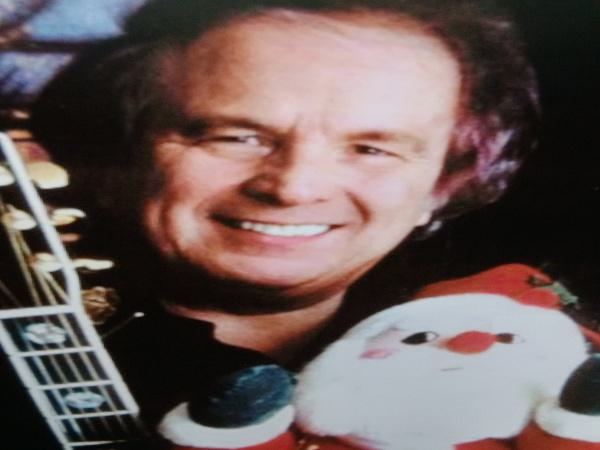

In [55]:
model_builder = ResNet50
preprocess_input = preprocess_input
IMG_SIZE = (224, 224)
last_conv_layer = "conv5_block3_out"

# The local path to our target image
image_path = 'data/test/spoof/'
image_path = os.path.join(git_dir,image_path)
image_str = random.choice(os.listdir(image_path))
image_path = os.path.join(image_path, image_str)



display(Image(image_path))


In [56]:
def vectorize_image(img_path, size):
    '''
    Vectorize the given image to get a numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    return array

## Make Predictions

In [57]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from sklearn.metrics import accuracy_score
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

In [58]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = ResNet50(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [59]:
def decode_predictions(model_prediction):
    if model_prediction > 0.5:
        return 'spoof'
    else:
        return 'live'

In [60]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=1

# First we'll train the model without Fine-tuning
resnet_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

In [61]:
vectorized_image = preprocess_input(vectorize_image(image_path, size=IMG_SIZE))
resnet_model.load_weights(model_string)
# resnet_model.layers[-1].activation = None # Removing the last layer as it is the softmax layer used for classification

model_prediction = resnet_model.predict(vectorized_image)
print(f"The predicted class is : {decode_predictions(model_prediction)}")

1/1 [==============================] - 2s 2s/step
The predicted class is : live


In [62]:
resnet_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x0000021BB13A3EB0>>

## GradCAM

In [63]:
import matplotlib.pyplot as plt
import matplotlib.cm as c_map

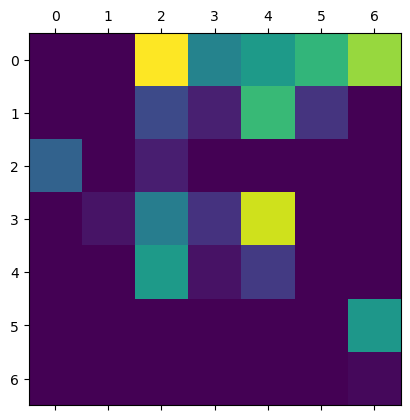

In [64]:
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, resnet_model, last_conv_layer))
plt.show()

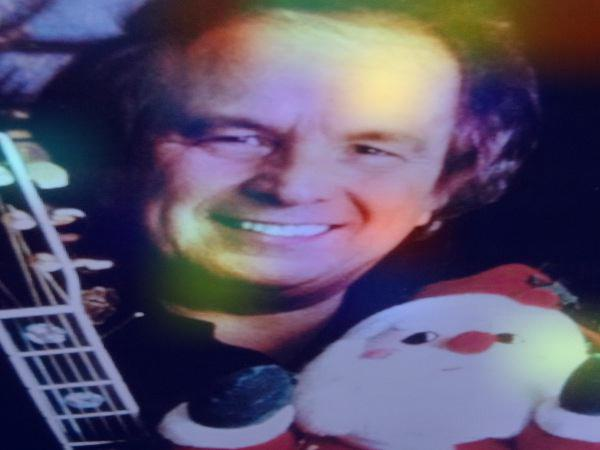

In [65]:
def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image
    
superimpose_gradcam(image_path, get_heatmap(vectorized_image, resnet_model, last_conv_layer))